In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)



Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)


Total training images: 1917
Total validation images: 504
Total test images: 630
Total images in dataset: 3051


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))


Training images (excluding 'random_occlusion'): 1704
Validation images (excluding 'random_occlusion'): 448
Test images (excluding 'random_occlusion'): 560
Total images (excluding 'random_occlusion'): 2712


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'chromatic_aberration', 'dirty_lens', 'blur', 'low_resolution', 'lens_flare', 'original', 'gaussian_noise', 'random_occlusion', 'motion_blur'}
Validation folders considered: {'chromatic_aberration', 'dirty_lens', 'blur', 'low_resolution', 'lens_flare', 'original', 'gaussian_noise', 'random_occlusion', 'motion_blur'}
Test folders considered: {'chromatic_aberration', 'dirty_lens', 'blur', 'low_resolution', 'lens_flare', 'original', 'gaussian_noise', 'random_occlusion', 'motion_blur'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))


Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']
Final Training images: 1704
Final Validation images: 448
Final Test images: 560
Total images after filtering: 2712


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'chromatic_aberration', 'dirty_lens', 'blur', 'low_resolution', 'lens_flare', 'original', 'gaussian_noise', 'motion_blur'}
Validation folders considered: {'chromatic_aberration', 'dirty_lens', 'blur', 'low_resolution', 'lens_flare', 'original', 'gaussian_noise', 'motion_blur'}
Test folders considered: {'chromatic_aberration', 'dirty_lens', 'blur', 'low_resolution', 'lens_flare', 'original', 'gaussian_noise', 'motion_blur'}


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

classes = train_ds.classes
print("Classes:", classes)
print(f"Number of classes: {len(classes)}")
print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")

# -----------------------------
# 2. Pretrained MobileNetV2 Model
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained MobileNetV2
print("üîÑ Loading pretrained MobileNetV2 from ImageNet...")
model = models.mobilenet_v2(pretrained=True)

# Replace final classification layer
# MobileNetV2 has a different structure: model.classifier[1] instead of model.fc
num_features = model.classifier[1].in_features  # Get input features (1280)
model.classifier[1] = nn.Linear(num_features, len(classes))  # Replace final layer
model = model.to(device)

print(f"‚úÖ Model loaded with {len(classes)} output classes")
print(f"üìä Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"üìä Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Model summary
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary not available")



Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']
Number of classes: 5
Train samples: 1704
Val samples: 448
Test samples: 560
Using device: cuda
üîÑ Loading pretrained MobileNetV2 from ImageNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13.6M/13.6M [00:01<00:00, 10.2MB/s]


‚úÖ Model loaded with 5 output classes
üìä Total parameters: 2,230,277
üìä Trainable parameters: 2,230,277
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]           


üìã Training Configuration:
‚îÇ Model: MobileNetV2 (pretrained)
‚îÇ Optimizer: Adam (lr=0.0001)
‚îÇ Loss Function: CrossEntropyLoss
‚îÇ Batch Size: 32
‚îÇ Device: cuda

üöÄ Starting MobileNetV2 Fine-tuning for 50 epochs...

üìà Epoch 1/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:24<00:00,  2.18it/s, Loss=0.8436, Acc=0.7001]


‚úÖ Training completed in 24.80s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:04<00:00,  3.09it/s, Loss=0.9127, Acc=0.5982]


‚úÖ Validation completed in 4.54s
üåü New best model found! Validation Loss: 0.9127

üìä Epoch 1 Summary:
‚îÇ Train Loss: 0.8436 | Train Acc: 0.7001
‚îÇ Val Loss:   0.9127 | Val Acc:   0.5982
‚îÇ Train Time: 24.80s | Val Time: 4.54s
‚îÇ Total Epoch Time: 29.34s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 2/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.91it/s, Loss=0.1493, Acc=0.9724]


‚úÖ Training completed in 18.59s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.64it/s, Loss=0.9800, Acc=0.6116]


‚úÖ Validation completed in 3.02s

üìä Epoch 2 Summary:
‚îÇ Train Loss: 0.1493 | Train Acc: 0.9724
‚îÇ Val Loss:   0.9800 | Val Acc:   0.6116
‚îÇ Train Time: 18.59s | Val Time: 3.02s
‚îÇ Total Epoch Time: 21.61s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 3/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.95it/s, Loss=0.0589, Acc=0.9912]


‚úÖ Training completed in 18.29s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:02<00:00,  4.68it/s, Loss=0.9822, Acc=0.6696]


‚úÖ Validation completed in 2.99s

üìä Epoch 3 Summary:
‚îÇ Train Loss: 0.0589 | Train Acc: 0.9912
‚îÇ Val Loss:   0.9822 | Val Acc:   0.6696
‚îÇ Train Time: 18.29s | Val Time: 2.99s
‚îÇ Total Epoch Time: 21.29s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 4/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.90it/s, Loss=0.0290, Acc=0.9965]


‚úÖ Training completed in 18.59s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.50it/s, Loss=1.0621, Acc=0.6317]


‚úÖ Validation completed in 3.11s

üìä Epoch 4 Summary:
‚îÇ Train Loss: 0.0290 | Train Acc: 0.9965
‚îÇ Val Loss:   1.0621 | Val Acc:   0.6317
‚îÇ Train Time: 18.59s | Val Time: 3.11s
‚îÇ Total Epoch Time: 21.71s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 5/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.91it/s, Loss=0.0124, Acc=0.9988]


‚úÖ Training completed in 18.54s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.54it/s, Loss=1.0037, Acc=0.6317]


‚úÖ Validation completed in 3.09s

üìä Epoch 5 Summary:
‚îÇ Train Loss: 0.0124 | Train Acc: 0.9988
‚îÇ Val Loss:   1.0037 | Val Acc:   0.6317
‚îÇ Train Time: 18.54s | Val Time: 3.09s
‚îÇ Total Epoch Time: 21.63s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 6/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.87it/s, Loss=0.0068, Acc=0.9994]


‚úÖ Training completed in 18.82s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.58it/s, Loss=1.0502, Acc=0.6339]


‚úÖ Validation completed in 3.06s

üìä Epoch 6 Summary:
‚îÇ Train Loss: 0.0068 | Train Acc: 0.9994
‚îÇ Val Loss:   1.0502 | Val Acc:   0.6339
‚îÇ Train Time: 18.82s | Val Time: 3.06s
‚îÇ Total Epoch Time: 21.89s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 7/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.88it/s, Loss=0.0079, Acc=0.9994]


‚úÖ Training completed in 18.76s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.53it/s, Loss=1.0869, Acc=0.6562]


‚úÖ Validation completed in 3.10s

üìä Epoch 7 Summary:
‚îÇ Train Loss: 0.0079 | Train Acc: 0.9994
‚îÇ Val Loss:   1.0869 | Val Acc:   0.6562
‚îÇ Train Time: 18.76s | Val Time: 3.10s
‚îÇ Total Epoch Time: 21.86s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 8/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.92it/s, Loss=0.0148, Acc=0.9982]


‚úÖ Training completed in 18.47s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.55it/s, Loss=1.0942, Acc=0.6384]


‚úÖ Validation completed in 3.08s

üìä Epoch 8 Summary:
‚îÇ Train Loss: 0.0148 | Train Acc: 0.9982
‚îÇ Val Loss:   1.0942 | Val Acc:   0.6384
‚îÇ Train Time: 18.47s | Val Time: 3.08s
‚îÇ Total Epoch Time: 21.55s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 9/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.88it/s, Loss=0.0173, Acc=0.9977]


‚úÖ Training completed in 18.77s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.52it/s, Loss=1.0048, Acc=0.6607]


‚úÖ Validation completed in 3.10s

üìä Epoch 9 Summary:
‚îÇ Train Loss: 0.0173 | Train Acc: 0.9977
‚îÇ Val Loss:   1.0048 | Val Acc:   0.6607
‚îÇ Train Time: 18.77s | Val Time: 3.10s
‚îÇ Total Epoch Time: 21.87s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 10/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.76it/s, Loss=0.0095, Acc=0.9994]


‚úÖ Training completed in 19.58s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.55it/s, Loss=1.2056, Acc=0.6004]


‚úÖ Validation completed in 3.08s

üìä Epoch 10 Summary:
‚îÇ Train Loss: 0.0095 | Train Acc: 0.9994
‚îÇ Val Loss:   1.2056 | Val Acc:   0.6004
‚îÇ Train Time: 19.58s | Val Time: 3.08s
‚îÇ Total Epoch Time: 22.67s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 11/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:21<00:00,  2.46it/s, Loss=0.0341, Acc=0.9924]


‚úÖ Training completed in 21.97s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.58it/s, Loss=1.0119, Acc=0.6562]


‚úÖ Validation completed in 3.06s

üìä Epoch 11 Summary:
‚îÇ Train Loss: 0.0341 | Train Acc: 0.9924
‚îÇ Val Loss:   1.0119 | Val Acc:   0.6562
‚îÇ Train Time: 21.97s | Val Time: 3.06s
‚îÇ Total Epoch Time: 25.04s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 12/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.84it/s, Loss=0.0086, Acc=0.9994]


‚úÖ Training completed in 18.99s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.46it/s, Loss=1.0032, Acc=0.6607]


‚úÖ Validation completed in 3.14s

üìä Epoch 12 Summary:
‚îÇ Train Loss: 0.0086 | Train Acc: 0.9994
‚îÇ Val Loss:   1.0032 | Val Acc:   0.6607
‚îÇ Train Time: 18.99s | Val Time: 3.14s
‚îÇ Total Epoch Time: 22.14s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 13/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.84it/s, Loss=0.0164, Acc=0.9947]


‚úÖ Training completed in 19.02s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.55it/s, Loss=1.0636, Acc=0.6696]


‚úÖ Validation completed in 3.08s

üìä Epoch 13 Summary:
‚îÇ Train Loss: 0.0164 | Train Acc: 0.9947
‚îÇ Val Loss:   1.0636 | Val Acc:   0.6696
‚îÇ Train Time: 19.02s | Val Time: 3.08s
‚îÇ Total Epoch Time: 22.10s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 14/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.84it/s, Loss=0.0067, Acc=0.9994]


‚úÖ Training completed in 19.03s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.57it/s, Loss=1.1068, Acc=0.6496]


‚úÖ Validation completed in 3.06s

üìä Epoch 14 Summary:
‚îÇ Train Loss: 0.0067 | Train Acc: 0.9994
‚îÇ Val Loss:   1.1068 | Val Acc:   0.6496
‚îÇ Train Time: 19.03s | Val Time: 3.06s
‚îÇ Total Epoch Time: 22.10s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 15/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.81it/s, Loss=0.0034, Acc=1.0000]


‚úÖ Training completed in 19.21s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.58it/s, Loss=1.1042, Acc=0.6496]


‚úÖ Validation completed in 3.06s

üìä Epoch 15 Summary:
‚îÇ Train Loss: 0.0034 | Train Acc: 1.0000
‚îÇ Val Loss:   1.1042 | Val Acc:   0.6496
‚îÇ Train Time: 19.21s | Val Time: 3.06s
‚îÇ Total Epoch Time: 22.27s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 16/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.80it/s, Loss=0.0014, Acc=1.0000]


‚úÖ Training completed in 19.31s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.63it/s, Loss=1.0823, Acc=0.6629]


‚úÖ Validation completed in 3.03s

üìä Epoch 16 Summary:
‚îÇ Train Loss: 0.0014 | Train Acc: 1.0000
‚îÇ Val Loss:   1.0823 | Val Acc:   0.6629
‚îÇ Train Time: 19.31s | Val Time: 3.03s
‚îÇ Total Epoch Time: 22.34s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 17/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.83it/s, Loss=0.0014, Acc=1.0000]


‚úÖ Training completed in 19.05s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.55it/s, Loss=1.0963, Acc=0.6473]


‚úÖ Validation completed in 3.08s

üìä Epoch 17 Summary:
‚îÇ Train Loss: 0.0014 | Train Acc: 1.0000
‚îÇ Val Loss:   1.0963 | Val Acc:   0.6473
‚îÇ Train Time: 19.05s | Val Time: 3.08s
‚îÇ Total Epoch Time: 22.14s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 18/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.80it/s, Loss=0.0008, Acc=1.0000]


‚úÖ Training completed in 19.27s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.57it/s, Loss=1.0678, Acc=0.6384]


‚úÖ Validation completed in 3.07s

üìä Epoch 18 Summary:
‚îÇ Train Loss: 0.0008 | Train Acc: 1.0000
‚îÇ Val Loss:   1.0678 | Val Acc:   0.6384
‚îÇ Train Time: 19.27s | Val Time: 3.07s
‚îÇ Total Epoch Time: 22.34s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 19/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.86it/s, Loss=0.0012, Acc=1.0000]


‚úÖ Training completed in 18.87s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.56it/s, Loss=1.0325, Acc=0.6719]


‚úÖ Validation completed in 3.07s

üìä Epoch 19 Summary:
‚îÇ Train Loss: 0.0012 | Train Acc: 1.0000
‚îÇ Val Loss:   1.0325 | Val Acc:   0.6719
‚îÇ Train Time: 18.87s | Val Time: 3.07s
‚îÇ Total Epoch Time: 21.94s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 20/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.81it/s, Loss=0.0009, Acc=1.0000]


‚úÖ Training completed in 19.22s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.53it/s, Loss=1.0487, Acc=0.6585]


‚úÖ Validation completed in 3.09s

üìä Epoch 20 Summary:
‚îÇ Train Loss: 0.0009 | Train Acc: 1.0000
‚îÇ Val Loss:   1.0487 | Val Acc:   0.6585
‚îÇ Train Time: 19.22s | Val Time: 3.09s
‚îÇ Total Epoch Time: 22.31s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 21/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.81it/s, Loss=0.0026, Acc=1.0000]


‚úÖ Training completed in 19.24s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.62it/s, Loss=0.9889, Acc=0.6674]


‚úÖ Validation completed in 3.03s

üìä Epoch 21 Summary:
‚îÇ Train Loss: 0.0026 | Train Acc: 1.0000
‚îÇ Val Loss:   0.9889 | Val Acc:   0.6674
‚îÇ Train Time: 19.24s | Val Time: 3.03s
‚îÇ Total Epoch Time: 22.28s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 22/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.81it/s, Loss=0.0070, Acc=0.9994]


‚úÖ Training completed in 19.25s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.62it/s, Loss=1.1445, Acc=0.6451]


‚úÖ Validation completed in 3.03s

üìä Epoch 22 Summary:
‚îÇ Train Loss: 0.0070 | Train Acc: 0.9994
‚îÇ Val Loss:   1.1445 | Val Acc:   0.6451
‚îÇ Train Time: 19.25s | Val Time: 3.03s
‚îÇ Total Epoch Time: 22.28s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 23/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:20<00:00,  2.67it/s, Loss=0.0070, Acc=0.9988]


‚úÖ Training completed in 20.24s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:04<00:00,  3.01it/s, Loss=1.3027, Acc=0.6205]


‚úÖ Validation completed in 4.65s

üìä Epoch 23 Summary:
‚îÇ Train Loss: 0.0070 | Train Acc: 0.9988
‚îÇ Val Loss:   1.3027 | Val Acc:   0.6205
‚îÇ Train Time: 20.24s | Val Time: 4.65s
‚îÇ Total Epoch Time: 24.89s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 24/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:22<00:00,  2.37it/s, Loss=0.0021, Acc=1.0000]


‚úÖ Training completed in 22.77s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:04<00:00,  3.12it/s, Loss=1.1252, Acc=0.6652]


‚úÖ Validation completed in 4.49s

üìä Epoch 24 Summary:
‚îÇ Train Loss: 0.0021 | Train Acc: 1.0000
‚îÇ Val Loss:   1.1252 | Val Acc:   0.6652
‚îÇ Train Time: 22.77s | Val Time: 4.49s
‚îÇ Total Epoch Time: 27.26s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 25/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.80it/s, Loss=0.0091, Acc=0.9994]


‚úÖ Training completed in 19.27s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.44it/s, Loss=1.2287, Acc=0.6272]


‚úÖ Validation completed in 3.16s

üìä Epoch 25 Summary:
‚îÇ Train Loss: 0.0091 | Train Acc: 0.9994
‚îÇ Val Loss:   1.2287 | Val Acc:   0.6272
‚îÇ Train Time: 19.27s | Val Time: 3.16s
‚îÇ Total Epoch Time: 22.43s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 26/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.82it/s, Loss=0.0138, Acc=0.9965]


‚úÖ Training completed in 19.13s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.63it/s, Loss=1.3437, Acc=0.6540]


‚úÖ Validation completed in 3.03s

üìä Epoch 26 Summary:
‚îÇ Train Loss: 0.0138 | Train Acc: 0.9965
‚îÇ Val Loss:   1.3437 | Val Acc:   0.6540
‚îÇ Train Time: 19.13s | Val Time: 3.03s
‚îÇ Total Epoch Time: 22.16s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 27/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.83it/s, Loss=0.0171, Acc=0.9947]


‚úÖ Training completed in 19.05s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.57it/s, Loss=1.3576, Acc=0.6763]


‚úÖ Validation completed in 3.07s

üìä Epoch 27 Summary:
‚îÇ Train Loss: 0.0171 | Train Acc: 0.9947
‚îÇ Val Loss:   1.3576 | Val Acc:   0.6763
‚îÇ Train Time: 19.05s | Val Time: 3.07s
‚îÇ Total Epoch Time: 22.12s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 28/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:20<00:00,  2.69it/s, Loss=0.0366, Acc=0.9906]


‚úÖ Training completed in 20.09s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.23it/s, Loss=1.3586, Acc=0.6161]


‚úÖ Validation completed in 3.31s

üìä Epoch 28 Summary:
‚îÇ Train Loss: 0.0366 | Train Acc: 0.9906
‚îÇ Val Loss:   1.3586 | Val Acc:   0.6161
‚îÇ Train Time: 20.09s | Val Time: 3.31s
‚îÇ Total Epoch Time: 23.41s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 29/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:20<00:00,  2.67it/s, Loss=0.0102, Acc=0.9988]


‚úÖ Training completed in 20.20s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.40it/s, Loss=1.0774, Acc=0.6674]


‚úÖ Validation completed in 3.18s

üìä Epoch 29 Summary:
‚îÇ Train Loss: 0.0102 | Train Acc: 0.9988
‚îÇ Val Loss:   1.0774 | Val Acc:   0.6674
‚îÇ Train Time: 20.20s | Val Time: 3.18s
‚îÇ Total Epoch Time: 23.38s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 30/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:20<00:00,  2.59it/s, Loss=0.0036, Acc=0.9994]


‚úÖ Training completed in 20.88s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.57it/s, Loss=1.2631, Acc=0.6652]


‚úÖ Validation completed in 3.07s

üìä Epoch 30 Summary:
‚îÇ Train Loss: 0.0036 | Train Acc: 0.9994
‚îÇ Val Loss:   1.2631 | Val Acc:   0.6652
‚îÇ Train Time: 20.88s | Val Time: 3.07s
‚îÇ Total Epoch Time: 23.96s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 31/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.81it/s, Loss=0.0128, Acc=0.9982]


‚úÖ Training completed in 19.22s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.53it/s, Loss=1.3731, Acc=0.7098]


‚úÖ Validation completed in 3.09s

üìä Epoch 31 Summary:
‚îÇ Train Loss: 0.0128 | Train Acc: 0.9982
‚îÇ Val Loss:   1.3731 | Val Acc:   0.7098
‚îÇ Train Time: 19.22s | Val Time: 3.09s
‚îÇ Total Epoch Time: 22.32s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 32/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.85it/s, Loss=0.0301, Acc=0.9930]


‚úÖ Training completed in 18.98s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.36it/s, Loss=1.5470, Acc=0.5960]


‚úÖ Validation completed in 3.22s

üìä Epoch 32 Summary:
‚îÇ Train Loss: 0.0301 | Train Acc: 0.9930
‚îÇ Val Loss:   1.5470 | Val Acc:   0.5960
‚îÇ Train Time: 18.98s | Val Time: 3.22s
‚îÇ Total Epoch Time: 22.20s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 33/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.84it/s, Loss=0.0102, Acc=0.9977]


‚úÖ Training completed in 19.03s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.61it/s, Loss=1.3334, Acc=0.6607]


‚úÖ Validation completed in 3.04s

üìä Epoch 33 Summary:
‚îÇ Train Loss: 0.0102 | Train Acc: 0.9977
‚îÇ Val Loss:   1.3334 | Val Acc:   0.6607
‚îÇ Train Time: 19.03s | Val Time: 3.04s
‚îÇ Total Epoch Time: 22.08s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 34/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.81it/s, Loss=0.0039, Acc=0.9994]


‚úÖ Training completed in 19.22s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:02<00:00,  4.69it/s, Loss=1.1656, Acc=0.6853]


‚úÖ Validation completed in 2.99s

üìä Epoch 34 Summary:
‚îÇ Train Loss: 0.0039 | Train Acc: 0.9994
‚îÇ Val Loss:   1.1656 | Val Acc:   0.6853
‚îÇ Train Time: 19.22s | Val Time: 2.99s
‚îÇ Total Epoch Time: 22.21s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 35/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.83it/s, Loss=0.0024, Acc=1.0000]


‚úÖ Training completed in 19.06s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.61it/s, Loss=1.2099, Acc=0.6964]


‚úÖ Validation completed in 3.04s

üìä Epoch 35 Summary:
‚îÇ Train Loss: 0.0024 | Train Acc: 1.0000
‚îÇ Val Loss:   1.2099 | Val Acc:   0.6964
‚îÇ Train Time: 19.06s | Val Time: 3.04s
‚îÇ Total Epoch Time: 22.11s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 36/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.79it/s, Loss=0.0017, Acc=1.0000]


‚úÖ Training completed in 19.36s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.40it/s, Loss=1.2527, Acc=0.6808]


‚úÖ Validation completed in 3.19s

üìä Epoch 36 Summary:
‚îÇ Train Loss: 0.0017 | Train Acc: 1.0000
‚îÇ Val Loss:   1.2527 | Val Acc:   0.6808
‚îÇ Train Time: 19.36s | Val Time: 3.19s
‚îÇ Total Epoch Time: 22.55s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 37/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.84it/s, Loss=0.0012, Acc=1.0000]


‚úÖ Training completed in 19.04s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.58it/s, Loss=1.2812, Acc=0.6786]


‚úÖ Validation completed in 3.06s

üìä Epoch 37 Summary:
‚îÇ Train Loss: 0.0012 | Train Acc: 1.0000
‚îÇ Val Loss:   1.2812 | Val Acc:   0.6786
‚îÇ Train Time: 19.04s | Val Time: 3.06s
‚îÇ Total Epoch Time: 22.10s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 38/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.84it/s, Loss=0.0021, Acc=0.9994]


‚úÖ Training completed in 18.99s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.63it/s, Loss=1.2049, Acc=0.6830]


‚úÖ Validation completed in 3.03s

üìä Epoch 38 Summary:
‚îÇ Train Loss: 0.0021 | Train Acc: 0.9994
‚îÇ Val Loss:   1.2049 | Val Acc:   0.6830
‚îÇ Train Time: 18.99s | Val Time: 3.03s
‚îÇ Total Epoch Time: 22.02s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 39/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.80it/s, Loss=0.0013, Acc=1.0000]


‚úÖ Training completed in 19.28s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.46it/s, Loss=1.0614, Acc=0.6964]


‚úÖ Validation completed in 3.14s

üìä Epoch 39 Summary:
‚îÇ Train Loss: 0.0013 | Train Acc: 1.0000
‚îÇ Val Loss:   1.0614 | Val Acc:   0.6964
‚îÇ Train Time: 19.28s | Val Time: 3.14s
‚îÇ Total Epoch Time: 22.42s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 40/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.85it/s, Loss=0.0011, Acc=1.0000]


‚úÖ Training completed in 18.98s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.56it/s, Loss=1.1276, Acc=0.6897]


‚úÖ Validation completed in 3.07s

üìä Epoch 40 Summary:
‚îÇ Train Loss: 0.0011 | Train Acc: 1.0000
‚îÇ Val Loss:   1.1276 | Val Acc:   0.6897
‚îÇ Train Time: 18.98s | Val Time: 3.07s
‚îÇ Total Epoch Time: 22.05s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 41/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.85it/s, Loss=0.0008, Acc=1.0000]


‚úÖ Training completed in 18.97s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  3.97it/s, Loss=1.1865, Acc=0.6719]


‚úÖ Validation completed in 3.53s

üìä Epoch 41 Summary:
‚îÇ Train Loss: 0.0008 | Train Acc: 1.0000
‚îÇ Val Loss:   1.1865 | Val Acc:   0.6719
‚îÇ Train Time: 18.97s | Val Time: 3.53s
‚îÇ Total Epoch Time: 22.50s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 42/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:23<00:00,  2.31it/s, Loss=0.0005, Acc=1.0000]


‚úÖ Training completed in 23.35s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.61it/s, Loss=1.1650, Acc=0.6629]


‚úÖ Validation completed in 3.04s

üìä Epoch 42 Summary:
‚îÇ Train Loss: 0.0005 | Train Acc: 1.0000
‚îÇ Val Loss:   1.1650 | Val Acc:   0.6629
‚îÇ Train Time: 23.35s | Val Time: 3.04s
‚îÇ Total Epoch Time: 26.39s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 43/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.85it/s, Loss=0.0035, Acc=1.0000]


‚úÖ Training completed in 18.98s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.61it/s, Loss=1.2568, Acc=0.6674]


‚úÖ Validation completed in 3.04s

üìä Epoch 43 Summary:
‚îÇ Train Loss: 0.0035 | Train Acc: 1.0000
‚îÇ Val Loss:   1.2568 | Val Acc:   0.6674
‚îÇ Train Time: 18.98s | Val Time: 3.04s
‚îÇ Total Epoch Time: 22.02s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 44/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.82it/s, Loss=0.0073, Acc=0.9977]


‚úÖ Training completed in 19.17s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.52it/s, Loss=1.0307, Acc=0.7188]


‚úÖ Validation completed in 3.10s

üìä Epoch 44 Summary:
‚îÇ Train Loss: 0.0073 | Train Acc: 0.9977
‚îÇ Val Loss:   1.0307 | Val Acc:   0.7188
‚îÇ Train Time: 19.17s | Val Time: 3.10s
‚îÇ Total Epoch Time: 22.27s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 45/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.84it/s, Loss=0.0038, Acc=0.9988]


‚úÖ Training completed in 19.02s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:02<00:00,  4.73it/s, Loss=1.1407, Acc=0.6942]


‚úÖ Validation completed in 2.97s

üìä Epoch 45 Summary:
‚îÇ Train Loss: 0.0038 | Train Acc: 0.9988
‚îÇ Val Loss:   1.1407 | Val Acc:   0.6942
‚îÇ Train Time: 19.02s | Val Time: 2.97s
‚îÇ Total Epoch Time: 21.99s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 46/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.88it/s, Loss=0.0020, Acc=0.9994]


‚úÖ Training completed in 18.76s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.58it/s, Loss=1.2059, Acc=0.6875]


‚úÖ Validation completed in 3.06s

üìä Epoch 46 Summary:
‚îÇ Train Loss: 0.0020 | Train Acc: 0.9994
‚îÇ Val Loss:   1.2059 | Val Acc:   0.6875
‚îÇ Train Time: 18.76s | Val Time: 3.06s
‚îÇ Total Epoch Time: 21.83s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 47/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:20<00:00,  2.69it/s, Loss=0.0006, Acc=1.0000]


‚úÖ Training completed in 20.08s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.57it/s, Loss=1.2095, Acc=0.6987]


‚úÖ Validation completed in 3.07s

üìä Epoch 47 Summary:
‚îÇ Train Loss: 0.0006 | Train Acc: 1.0000
‚îÇ Val Loss:   1.2095 | Val Acc:   0.6987
‚îÇ Train Time: 20.08s | Val Time: 3.07s
‚îÇ Total Epoch Time: 23.16s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 48/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.87it/s, Loss=0.0014, Acc=0.9994]


‚úÖ Training completed in 18.85s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.61it/s, Loss=1.1790, Acc=0.6808]


‚úÖ Validation completed in 3.04s

üìä Epoch 48 Summary:
‚îÇ Train Loss: 0.0014 | Train Acc: 0.9994
‚îÇ Val Loss:   1.1790 | Val Acc:   0.6808
‚îÇ Train Time: 18.85s | Val Time: 3.04s
‚îÇ Total Epoch Time: 21.89s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 49/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:18<00:00,  2.85it/s, Loss=0.0016, Acc=1.0000]


‚úÖ Training completed in 18.98s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.58it/s, Loss=1.2147, Acc=0.7232]


‚úÖ Validation completed in 3.06s

üìä Epoch 49 Summary:
‚îÇ Train Loss: 0.0016 | Train Acc: 1.0000
‚îÇ Val Loss:   1.2147 | Val Acc:   0.7232
‚îÇ Train Time: 18.98s | Val Time: 3.06s
‚îÇ Total Epoch Time: 22.04s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 50/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:19<00:00,  2.80it/s, Loss=0.0008, Acc=1.0000]


‚úÖ Training completed in 19.26s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 14/14 [00:03<00:00,  4.58it/s, Loss=1.2247, Acc=0.7232]


‚úÖ Validation completed in 3.06s

üìä Epoch 50 Summary:
‚îÇ Train Loss: 0.0008 | Train Acc: 1.0000
‚îÇ Val Loss:   1.2247 | Val Acc:   0.7232
‚îÇ Train Time: 19.26s | Val Time: 3.06s
‚îÇ Total Epoch Time: 22.33s
‚îÇ Best Val Loss: 0.9127 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üíæ Best model saved as 'best_cricket_mobilenetv2.pth'
üìä Best model stats:
‚îÇ Best Epoch: 1
‚îÇ Best Val Loss: 0.9127
‚îÇ Best Val Acc: 0.5982

üíæ Training history saved to 'cricket_mobilenetv2_history_pretrained.csv'

üéâ MobileNetV2 Fine-tuning Complete!
Total Training Time: 1132.83s (18.9 minutes)
Average Epoch Time: 22.66s

üß™ Loading Best Model for Testing...
‚úÖ Best model from epoch 1 loaded successfully!


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 18/18 [00:07<00:00,  2.32it/s]


‚úÖ Testing completed in 7.78s

üìã Classification Report:
                 precision    recall  f1-score   support

  boundary_save       0.76      0.76      0.76       152
catching_a_ball       0.50      0.46      0.48       104
    diving_stop       0.21      0.18      0.19        56
        run_out       0.61      0.72      0.66       128
       stumping       0.58      0.54      0.56       120

       accuracy                           0.59       560
      macro avg       0.53      0.53      0.53       560
   weighted avg       0.58      0.59      0.58       560

üéØ Test Accuracy: 0.5893

üìä Cricket Classification Performance (MobileNetV2):
‚îÇ Best Validation Loss: 0.9127 (Epoch 1)
‚îÇ Best Validation Acc:  0.5982 (Epoch 1)
‚îÇ Final Test Accuracy:  0.5893
‚îÇ Val-Test Gap:         0.0089

üíæ Files saved:
‚îÇ best_cricket_mobilenetv2.pth - Best model weights
‚îÇ cricket_mobilenetv2_history.csv - Training metrics


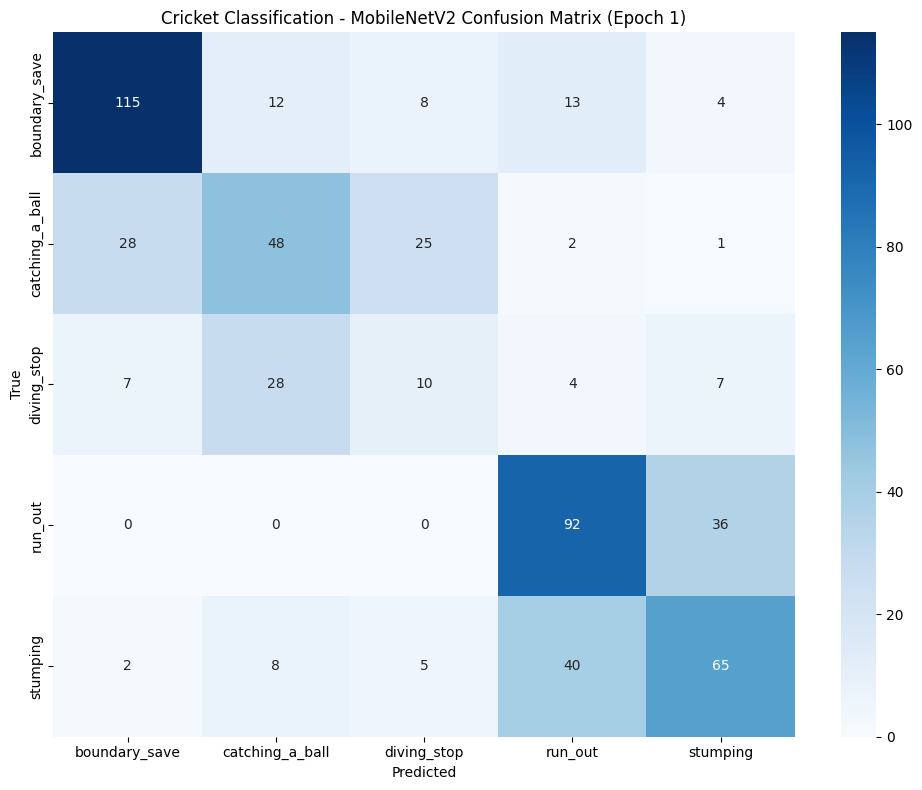

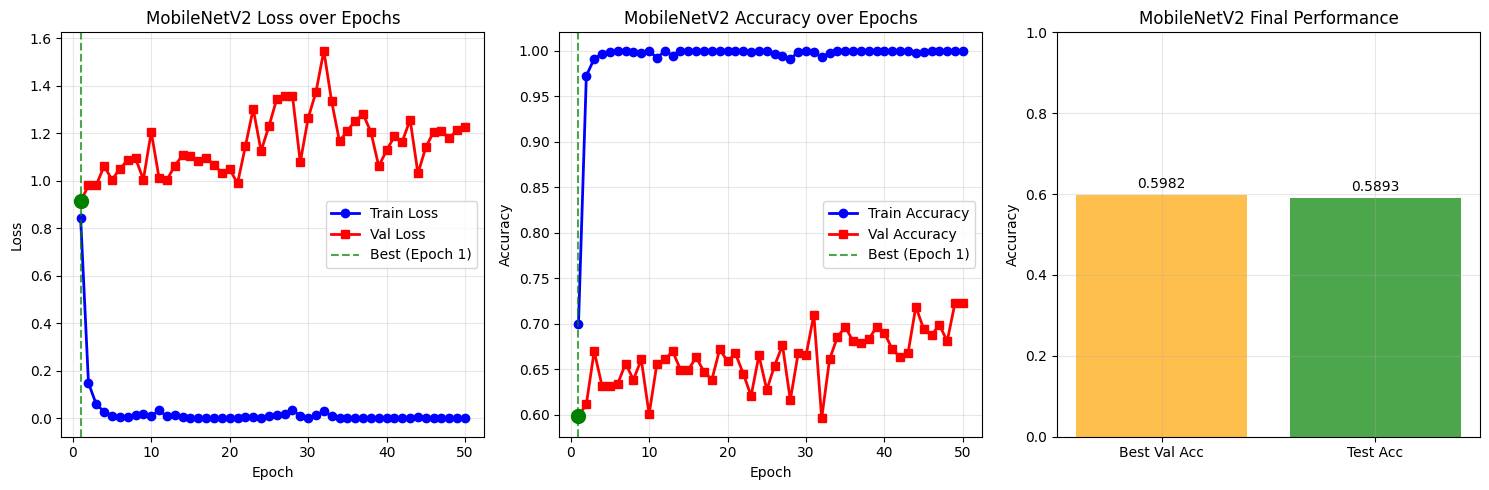


‚è∞ Final Timing Summary:
‚îÇ Total Training: 1132.83s (18.9 min)
‚îÇ Average per Epoch: 22.66s
‚îÇ Testing Time: 7.78s
‚îÇ Total Runtime: 1140.61s

üì± MobileNetV2 Advantages:
‚îÇ Lightweight: ~3.5M parameters vs ~25M (ResNet50)
‚îÇ Mobile-optimized: Designed for resource-constrained devices
‚îÇ Faster training: Typically trains faster than ResNet50
‚îÇ Lower memory: Uses less GPU memory during training


In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning

print(f"\nüìã Training Configuration:")
print(f"‚îÇ Model: MobileNetV2 (pretrained)")
print(f"‚îÇ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"‚îÇ Loss Function: CrossEntropyLoss")
print(f"‚îÇ Batch Size: 32")
print(f"‚îÇ Device: {device}")

# -----------------------------
# 4. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking (using val_loss for fine-tuning)
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
best_val_acc = 0.0

print(f"\nüöÄ Starting MobileNetV2 Fine-tuning for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\nüìà Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("üîÑ Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"‚úÖ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("üîç Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"‚úÖ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model (using val_loss for fine-tuning)
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"üåü New best model found! Validation Loss: {val_loss:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\nüìä Epoch {epoch+1} Summary:")
    print(f"‚îÇ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"‚îÇ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"‚îÇ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"‚îÇ Total Epoch Time: {epoch_time:.2f}s")
    print(f"‚îÇ Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"‚îÇ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_mobilenetv2_pretrained.pth')
    print(f"\nüíæ Best model saved as 'best_cricket_mobilenetv2.pth'")
    print(f"üìä Best model stats:")
    print(f"‚îÇ Best Epoch: {best_epoch}")
    print(f"‚îÇ Best Val Loss: {best_val_loss:.4f}")
    print(f"‚îÇ Best Val Acc: {best_val_acc:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_mobilenetv2_history_pretrained.csv', index=False)
print("\nüíæ Training history saved to 'cricket_mobilenetv2_history_pretrained.csv'")

print(f"\nüéâ MobileNetV2 Fine-tuning Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\nüß™ Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"‚úÖ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"‚úÖ Testing completed in {test_time:.2f}s")
print("\nüìã Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"üéØ Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\nüìä Cricket Classification Performance (MobileNetV2):")
print(f"‚îÇ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"‚îÇ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

print(f"\nüíæ Files saved:")
print(f"‚îÇ best_cricket_mobilenetv2.pth - Best model weights")
print(f"‚îÇ cricket_mobilenetv2_history.csv - Training metrics")

# -----------------------------
# 6. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - MobileNetV2 Confusion Matrix (Epoch {best_epoch})")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("MobileNetV2 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("MobileNetV2 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 3, 3)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("MobileNetV2 Final Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n‚è∞ Final Timing Summary:")
print(f"‚îÇ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"‚îÇ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"‚îÇ Testing Time: {test_time:.2f}s")
print(f"‚îÇ Total Runtime: {total_training_time + test_time:.2f}s")

# Model Comparison Info
print(f"\nüì± MobileNetV2 Advantages:")
print(f"‚îÇ Lightweight: ~3.5M parameters vs ~25M (ResNet50)")
print(f"‚îÇ Mobile-optimized: Designed for resource-constrained devices")
print(f"‚îÇ Faster training: Typically trains faster than ResNet50")
print(f"‚îÇ Lower memory: Uses less GPU memory during training")
